In [424]:
import pandas as pd
import pprint
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from impyute.imputation.cs import mice#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer#
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from missingpy import KNNImputer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set()
pd.set_option("display.max_rows", 8)
plt.rcParams['figure.figsize'] = (9, 6)
from missingpy import MissForest
import io
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn import decomposition
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
import sklearn.metrics as metrics


In [4]:
Dapp = pd.read_csv("horse-colic.data" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
Dtest = pd.read_csv("horse-colic.test" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
liste_drop = ["V22","V24","V25","V26","V27"]
Dapp = Dapp.drop(liste_drop , axis = 1)
Dtest = Dtest.drop(liste_drop , axis = 1)
Dapp = Dapp.replace("?",np.nan)
Dtest = Dtest.replace("?",np.nan)
Dtest
Dapp

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V23
0,2,1,530101,38.50,66,28,3,3,NaN,2,...,NaN,NaN,NaN,3,5,45.00,8.40,NaN,NaN,2
1,1,1,534817,39.2,88,20,NaN,NaN,4,1,...,NaN,NaN,NaN,4,2,50,85,2,2,2
2,2,1,530334,38.30,40,24,1,1,3,1,...,NaN,NaN,NaN,1,1,33.00,6.70,NaN,NaN,2
3,1,9,5290409,39.10,164,84,4,1,6,2,...,1,2,5.00,3,NaN,48.00,7.20,3,5.30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,2,1,527702,37.20,72,24,3,2,4,2,...,3,1,NaN,4,4,44.00,NaN,3,3.30,1
297,1,1,529386,37.50,72,30,4,3,4,1,...,2,1,NaN,3,5,60.00,6.80,NaN,NaN,1
298,1,1,530612,36.50,100,24,3,3,3,1,...,3,1,NaN,4,4,50.00,6.00,3,3.40,1
299,1,1,534618,37.2,40,20,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4,1,36,62,1,1,2


In [2]:
d = {}
liste_categorical = [] ; liste_numerical = []
for i in range(24):
    if(i in list(range(3)) + list(range(6 , 15)) + [16 , 17 , 20 , 23]):
        d["V"+str(i)] = "category"
        liste_categorical.append("V"+str(i))
    elif(i != 22):
        d["V"+str(i)] = "float64"
        liste_numerical.append("V"+str(i))
liste_categorical
liste_numerical

['V3', 'V4', 'V5', 'V15', 'V18', 'V19', 'V21']

In [158]:
d

{'V0': 'category',
 'V1': 'category',
 'V2': 'category',
 'V3': 'float64',
 'V4': 'float64',
 'V5': 'float64',
 'V6': 'category',
 'V7': 'category',
 'V8': 'category',
 'V9': 'category',
 'V10': 'category',
 'V11': 'category',
 'V12': 'category',
 'V13': 'category',
 'V14': 'category',
 'V15': 'float64',
 'V16': 'category',
 'V17': 'category',
 'V18': 'float64',
 'V19': 'float64',
 'V20': 'category',
 'V21': 'float64',
 'V23': 'category'}

In [437]:
Dapp = Dapp.astype(d)
Dtest = Dtest.astype(d)
Dapp_num = Dapp.select_dtypes(include=['float64']) ; Dapp_cat = Dapp.select_dtypes(include=['category'])
Dtest_num = Dtest.select_dtypes(include=['float64']) ; Dtest_cat = Dtest.select_dtypes(include=['category'])
Dtest_cat.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat.loc[: , "V9"], categories=["1","2","3"]))

NameError: name 'Dapp' is not defined

# Imputation multiple sur les variables numériques

In [160]:
def g(l): 
    return np.array([float(x) for x in l])

imputed_training=mice(np.array(list(map(g , Dapp_num.values))))
imputed_test = mice(np.array(list(map(g , Dtest_num.values))))

Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_training))))).round(2)
Dapp_num_imputed.columns = liste_numerical

Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_test))))).round(2)
Dtest_num_imputed.columns = liste_numerical

In [161]:
Dapp_num_imputed[Dapp_num_imputed < 0] = np.nan
Dtest_num_imputed[Dtest_num_imputed < 0] = np.nan

distances_app = pdist(Dapp_num_imputed.values, metric='euclidean')
dist_matrix_app = squareform(distances_app)
matrice_distance_app = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_app))))).round(2)

distances_test = pdist(Dtest_num_imputed.values, metric='euclidean')
dist_matrix_test = squareform(distances_test)
matrice_distance_test = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_test))))).round(2)
matrice_distance_test

In [162]:
imputer = KNNImputer(n_neighbors=15, weights="distance")
Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dapp_num_imputed)))))).round(2)

imputer = KNNImputer(n_neighbors=3, weights="distance")
Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dtest_num_imputed)))))).round(2)

Dapp_num_imputed.columns = liste_numerical ; Dtest_num_imputed.columns = liste_numerical

C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


In [79]:
{lab : 1-(len(Dtest_num[lab].dropna())/len(Dtest_num)) for lab in liste_numerical} 
#les proportions de données manquantes pour chaque variable numérique sur les données de test

{'V3': 0.13235294117647056,
 'V4': 0.02941176470588236,
 'V5': 0.19117647058823528,
 'V15': 0.7647058823529411,
 'V18': 0.11764705882352944,
 'V19': 0.1470588235294118,
 'V21': 0.5441176470588236}

In [80]:
{lab : 1-(len(Dapp_num[lab].dropna())/len(Dapp_num)) for lab in liste_numerical}
#les proportions de données manquantes pour chaque variable numérique sur les données d'apprentissage

{'V3': 0.19999999999999996,
 'V4': 0.07999999999999996,
 'V5': 0.19333333333333336,
 'V15': 0.8233333333333334,
 'V18': 0.09666666666666668,
 'V19': 0.10999999999999999,
 'V21': 0.6599999999999999}

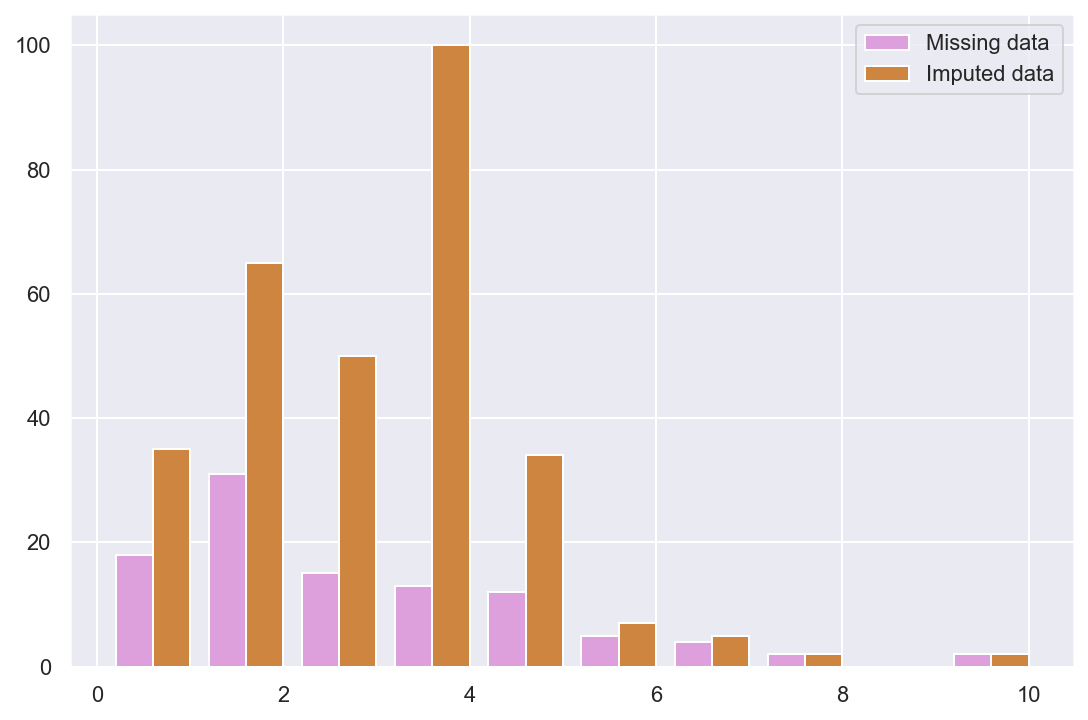

In [163]:
x = Dapp_num.V21
y = Dapp_num_imputed.V21
plt.hist([x, y], label=['Missing data', 'Imputed data'] , color = ["plum","peru"])
plt.legend(loc='upper right')
plt.show()

# Imputation multiple des variables qualitatives

In [164]:
Dapp_cat = Dapp_cat.drop(["V2"] , axis = 1) ; Dtest_cat = Dtest_cat.drop(["V2"] , axis = 1)
cat_cols = [Dapp_cat.columns.get_loc(col) for col in Dapp_cat.select_dtypes(['category']).columns.tolist()]

imputer = MissForest(random_state = 100) ## imputation pour les variables qualitatives à l'aide de fôrets aléatoires

Dapp_cat_imputed = imputer.fit_transform(Dapp_cat , cat_vars = cat_cols)
Dapp_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dapp_cat_imputed)))))
Dapp_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dapp_cat_imputed = Dapp_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)

Dtest_cat_imputed = imputer.transform(Dtest_cat)
Dtest_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dtest_cat_imputed)))))
Dtest_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dtest_cat_imputed = Dtest_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)
Dtest_cat_imputed.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat_imputed.loc[: , "V9"], categories=["1","2","3"]))
#une modalité de V9 n'est pas présente dans la variable V9 des données de test : il faut rajouter une catégorie
#pour la variable V9 des données de test

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [165]:
{lab : 1-(len(Dtest_cat[lab].dropna())/len(Dtest)) for lab in liste_categorical if(lab != "V2")} 
#les proportions de données manquantes pour chaque variable qualitative sur les données de test

{'V0': 0.014705882352941124,
 'V1': 0.0,
 'V6': 0.13235294117647056,
 'V7': 0.20588235294117652,
 'V8': 0.014705882352941124,
 'V9': 0.08823529411764708,
 'V10': 0.11764705882352944,
 'V11': 0.11764705882352944,
 'V12': 0.13235294117647056,
 'V13': 0.3970588235294118,
 'V14': 0.3970588235294118,
 'V16': 0.38235294117647056,
 'V17': 0.36764705882352944,
 'V20': 0.42647058823529416,
 'V23': 0.0}

In [166]:
{lab : 1-(len(Dapp_cat[lab].dropna())/len(Dapp)) for lab in liste_categorical if(lab != "V2")}
#les proportions de données manquantes pour chaque variable qualitative sur les données d'apprentissage

{'V0': 0.0033333333333332993,
 'V1': 0.0,
 'V6': 0.18666666666666665,
 'V7': 0.22999999999999998,
 'V8': 0.15666666666666662,
 'V9': 0.10666666666666669,
 'V10': 0.18333333333333335,
 'V11': 0.1466666666666666,
 'V12': 0.18666666666666665,
 'V13': 0.3466666666666667,
 'V14': 0.3533333333333334,
 'V16': 0.33999999999999997,
 'V17': 0.3933333333333333,
 'V20': 0.55,
 'V23': 0.0}

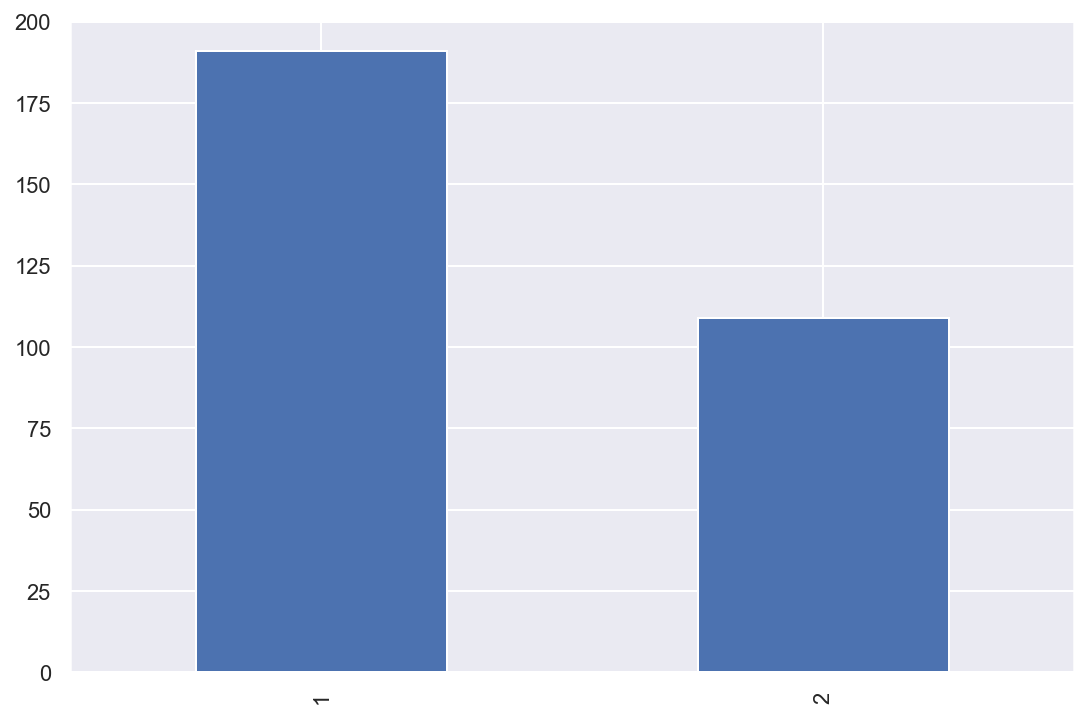

In [168]:
Dapp_cat_imputed.V23.value_counts().sort_index().plot(kind = "bar")
#en pratique, il est nécessaire de vérifier la distribution des variables avant\après imputation
#on trace donc des barplot pour avoir une idée

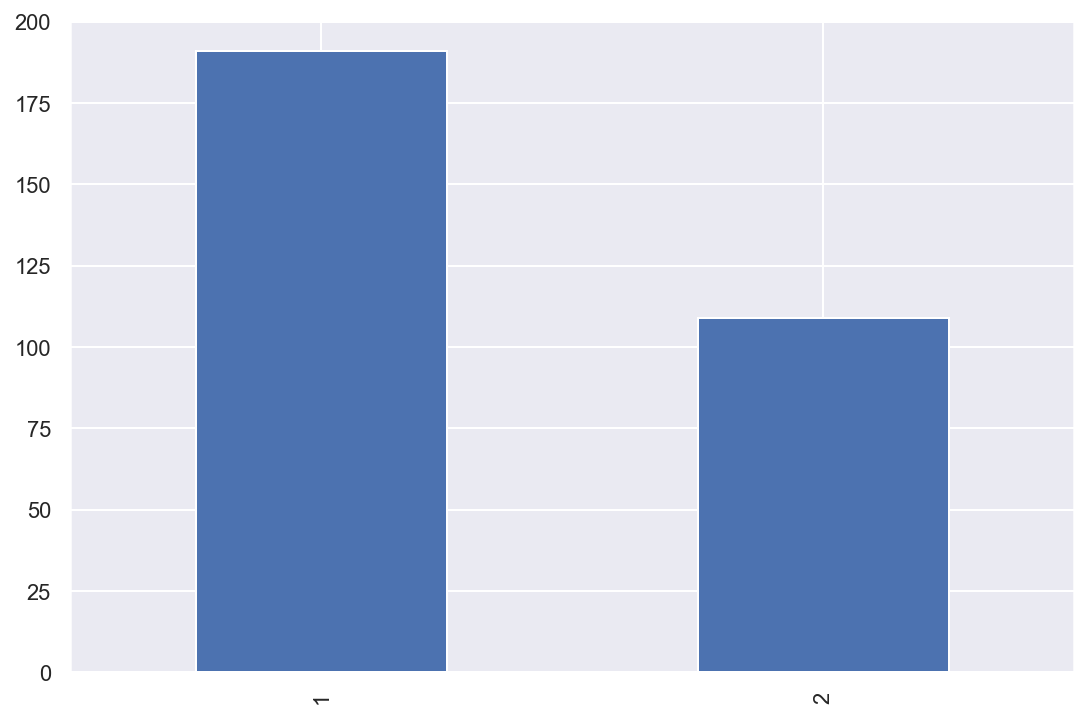

In [167]:
Dapp_cat["V23"].value_counts().sort_index().plot(kind = "bar")

# Nouveau jeu de données imputé

In [193]:
Dapp_imputed = pd.concat([Dapp_num_imputed.reset_index(drop=True), Dapp_cat_imputed], axis=1)
Dapp_imputed.columns = [int(x[1:]) for x in Dapp_imputed.columns]
Dapp_imputed = Dapp_imputed.sort_index(axis = 1)
Dapp_imputed.columns = ["V"+str(x) for x in Dapp_imputed.columns]

Dtest_imputed = pd.concat([Dtest_num_imputed.reset_index(drop=True), Dtest_cat_imputed], axis=1)
Dtest_imputed.columns = [int(x[1:]) for x in Dtest_imputed.columns]
Dtest_imputed = Dtest_imputed.sort_index(axis = 1)
Dtest_imputed.columns = ["V"+str(x) for x in Dtest_imputed.columns]
Dtest_imputed

,V0,V1,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V23
0,2,1,38.5,54.0,20.0,3,1,2,2,3,...,2,2,5.90,4,2,42.0,6.3,2,4.92,2
1,2,1,37.6,48.0,36.0,1,1,1,1,1,...,2,1,5.52,1,3,44.0,6.3,1,5.00,2
2,1,1,37.7,44.0,28.0,3,4,3,2,5,...,1,1,2.76,3,5,45.0,70.0,3,2.00,1
3,1,1,37.0,56.0,24.0,3,1,4,2,4,...,1,1,1.44,4,5,35.0,61.0,3,2.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2,1,37.8,42.0,40.0,1,1,1,1,1,...,2,1,7.81,3,3,36.0,6.2,1,3.09,2
65,1,1,38.0,60.0,12.0,1,1,2,1,2,...,1,1,1.97,1,4,44.0,65.0,3,2.00,1
66,2,1,38.0,42.0,12.0,3,3,3,1,1,...,2,1,6.10,4,1,37.0,5.8,2,3.10,2
67,2,1,37.6,88.0,36.0,3,1,1,1,3,...,1,3,1.50,4,4,44.0,6.0,2,8.88,1


In [198]:
Dapp_imputed

,V0,V1,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V23
0,2,1,38.5,66.0,28.0,3,3,4,2,5,...,1,1,5.75,3,5,45.0,8.40,2,3.57,2
1,1,1,39.2,88.0,20.0,3,3,4,1,3,...,2,1,1.56,4,2,50.0,85.00,2,2.00,2
2,2,1,38.3,40.0,24.0,1,1,3,1,3,...,1,1,6.02,1,1,33.0,6.70,1,3.26,2
3,1,9,39.1,164.0,84.0,4,1,6,2,2,...,1,2,5.00,3,5,48.0,7.20,3,5.30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,2,1,37.2,72.0,24.0,3,2,4,2,4,...,3,1,4.13,4,4,44.0,22.44,3,3.30,1
297,1,1,37.5,72.0,30.0,4,3,4,1,4,...,2,1,5.89,3,5,60.0,6.80,3,3.89,1
298,1,1,36.5,100.0,24.0,3,3,3,1,3,...,3,1,3.26,4,4,50.0,6.00,3,3.40,1
299,1,1,37.2,40.0,20.0,1,1,1,1,3,...,2,1,1.98,4,1,36.0,62.00,1,1.00,2


In [195]:
#Dtest_imputed.to_pickle("Dtest_imputed.pkl") 
#Dapp_imputed.to_pickle("Dapp_imputed.pkl")

# Importation Pickle des données d'entraînement/test

In [3]:
Dapp_imputed = pd.read_pickle("Dapp_imputed.pkl")
Dtest_imputed = pd.read_pickle("Dtest_imputed.pkl")

# Preprocessing sur le jeu de données

In [4]:
liste_cat_bis = [x for x in liste_categorical if(x not in ["V23" , "V2"] )]

In [5]:
def generate_data(X_app , X_test):
    Dapp_imputed_bis = copy.deepcopy(X_app) ; Dtest_imputed_bis = copy.deepcopy(X_test)
    scaler = MinMaxScaler()
    Dapp_imputed_bis[liste_numerical] = scaler.fit_transform(Dapp_imputed_bis[liste_numerical])
    Dapp_imputed_bis["V23"] = pd.Series([1 if(x=="1") else 0 for x in Dapp_imputed_bis["V23"]])
    Dapp_imputed_bis = Dapp_imputed_bis.astype({"V23" : "int32"})
    
    Dtest_imputed_bis[liste_numerical] = scaler.transform(Dtest_imputed_bis[liste_numerical])
    Dtest_imputed_bis["V23"] = pd.Series([1 if(x=="1") else 0 for x in Dtest_imputed_bis["V23"]])
    Dtest_imputed = Dtest_imputed_bis.astype({"V23" : "int32"})
    Dapp_imputed_bis = pd.get_dummies(Dapp_imputed_bis , columns = liste_cat_bis , drop_first = True)
    Dtest_imputed_bis = pd.get_dummies(Dtest_imputed_bis , columns = liste_cat_bis , drop_first = True)
    
    X_train = Dapp_imputed_bis.drop(["V23"] , axis = 1) ; Y_train = Dapp_imputed_bis["V23"]
    X_test = Dtest_imputed_bis.drop(["V23"] , axis = 1) ; Y_test = Dtest_imputed_bis["V23"]
    return X_train,Y_train,X_test,Y_test

## Données d'entraînement/test

# Régression logistique

In [417]:
X_train , Y_train , X_test , Y_test = generate_data(Dapp_imputed , Dtest_imputed)

In [419]:
Ytest_log = copy.deepcopy(Y_test)

In [322]:
matrice = []

In [8]:
logreg = LogisticRegression(penalty = "none", solver = "lbfgs" , max_iter = 5000 , tol = 1e-6)
logreg.fit(X_train , Y_train)
y_pred = logreg.predict(X_test)
y_fit = logreg.predict(X_train)
accuracy_score(y_pred, Y_test)

0.7941176470588235

In [9]:
accuracy_score(y_fit, Y_train)

0.9033333333333333

In [323]:
def param_selection_log(X, y,Cs):
    logreg = LogisticRegression(penalty = "l2", solver = "lbfgs" , max_iter = 5000 , tol = 1e-6)
    parameters = {'C':Cs}
    clf = GridSearchCV(logreg, parameters, cv = KFold(n_splits = 300) , n_jobs = -1)
    clf.fit(X_train, Y_train)
    return clf.best_params_

In [324]:
%%time
C_log = param_selection_log(X_train, Y_train , [.001 , 0.01 , 0.07, 0.1 ,0.4])["C"]
C_log

Wall time: 8.98 s


0.4

In [325]:
logreg = LogisticRegression(penalty = "l2", solver = "lbfgs" , max_iter = 5000 , tol = 1e-6 , C = C_log)
logreg.fit(X_train , Y_train)
y_pred = logreg.predict(X_test)
y_fit = logreg.predict(X_train)
accuracy_score(y_pred, Y_test)

0.8676470588235294

In [280]:
C_log

0.4

In [281]:
accuracy_score(y_fit, Y_train)

0.8833333333333333

In [326]:
matrice.append(["reg_log_P" , accuracy_score(y_fit, Y_train) , accuracy_score(y_pred, Y_test) ])

# SVM linéaire

In [420]:
Y_train = pd.Series([-1 if(y==0) else 1 for y in Y_train])
Y_test = pd.Series([-1 if(y==0) else 1 for y in Y_test])

In [367]:
#cette méthode est coûteuse, on opte pour une validation 3-fold
def svc_param_selection_lin(X, y,Cs):
    parameters = {'kernel':['linear'], 'C':Cs}
    svc = svm.SVC(gamma = 1 , coef0 = 0)
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 3))
    clf.fit(X_train, Y_train)
    return clf.best_params_

In [368]:
%%time
C_lin = svc_param_selection_lin(X_train, Y_train , [0.03 , 0.04,0.05,0.06 , 0.07])["C"]
C_lin

Wall time: 230 ms


0.06

In [435]:
svm = LinearSVC(C = C_lin , max_iter = 100000)
svm_lin = CalibratedClassifierCV(svm , cv = 3) #on se sert de cette fonction pour obtenir des probabilités
svm_lin.fit(X_train , Y_train)
y_pred = svm_lin.predict(X_test)
y_fit = svm_lin.predict(X_train)
accuracy_score(y_pred, Y_test)

0.8676470588235294

In [436]:
accuracy_score(y_fit, Y_train)

0.8866666666666667

In [331]:
matrice.append(["svm_lin" , accuracy_score(y_fit, Y_train) ,accuracy_score(y_pred, Y_test) ])

# SVM polynomiale

In [332]:
def svc_param_selection_poly(X, y,Cs , degree): #8-10 secondes
    parameters = {'kernel':['poly'], 'C':Cs , "degree" : degree}
    svc = svm.SVC(gamma = 1)
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 300) , n_jobs = -1)
    clf.fit(X_train, Y_train)
    return clf.best_params_

In [333]:
%%time
params_poly = svc_param_selection_poly(X_train, Y_train , [0.001 ,0.01 , 0.1 , 1] , list(range(1,3)))
params_poly

Wall time: 8.63 s


{'C': 0.01, 'degree': 2, 'kernel': 'poly'}

In [395]:
ksvm_poly = SVC(kernel="poly", degree = params_poly["degree"] , C = params_poly["C"] , gamma = 1 , probability = True)               
ksvm_poly.fit(X_train, Y_train)
y_pred = ksvm_poly.predict(X_test)
y_fit = ksvm_poly.predict(X_train)
accuracy_score(y_pred, Y_test)
## on décide de ne pas optimiser la constante du polynôme

0.8382352941176471

In [335]:
accuracy_score(y_fit, Y_train)

0.9166666666666666

In [336]:
matrice.append(["svm_poly" , accuracy_score(y_fit, Y_train) ,accuracy_score(y_pred, Y_test) ])

# SVM RBF

In [371]:
def svc_param_selection(X, y,Cs,Gs): #on se limite à une VC 3-fold car moins coûteuse
    parameters = {'C': Cs, 'gamma': Gs, 'kernel': ['rbf']}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters , return_train_score = True , cv = KFold(n_splits = 3))
    clf.fit(X_train, Y_train)
    return clf.best_params_

In [372]:
%%time
params = svc_param_selection(X_train, Y_train , [1, 1.2 , 1.3 , 1.4 ,1.5 , 1.6] , [0.0001 , 0.001 , 0.1 , 1])
params

Wall time: 1.13 s


{'C': 1.4, 'gamma': 0.1, 'kernel': 'rbf'}

In [398]:
svm_rbf = SVC(kernel="rbf", gamma = params["gamma"] , C = params["C"] , probability = True)               
svm_rbf.fit(X_train, Y_train)
y_pred = svm_rbf.predict(X_test)
y_fit = svm_rbf.predict(X_train)
accuracy_score(y_pred, Y_test)
#le calibrage  de gamma peut s'avérer très compliqué, il en est de même pour le choix du noyau ainsi que de la tolérance,
#on voit aussi que les performances sur les données de test sont moins bonnes

0.8088235294117647

In [114]:
params

{'C': 1.4, 'gamma': 0.1, 'kernel': 'rbf'}

In [115]:
accuracy_score(y_fit, Y_train)

0.9366666666666666

In [340]:
matrice.append(["svm_rbf" , accuracy_score(y_fit, Y_train) , accuracy_score(y_pred, Y_test) ])

## Random Forest

In [273]:
def oob_m(liste):
    l = []
    for m in liste:
        clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 ,
                             max_features = m,
                             oob_score = True)
        clf.fit(X_train, Y_train)
        l.append((m , clf.oob_score_))
    return min(l , key = lambda x : x[1])[0]

In [202]:
%%time
m = oob_m(range(1,8))
clf = RandomForestClassifier(random_state = 0,
                             n_estimators = 100,
                             max_features = m
                             oob_score = True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_fit = clf.predict(X_train)
accuracy_score(y_pred, Y_test)

Wall time: 635 ms


0.8382352941176471

In [203]:
accuracy_score(y_fit, Y_train)


1.0

In [341]:
def rfc_CV(ms , ds):
    rfc = RandomForestClassifier(random_state = 0, n_estimators = 100)
    param_grid = {'max_features': ms , "max_depth" : ds}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= KFold(n_splits = 3) , n_jobs = -1)
    CV_rfc.fit(X_train, Y_train)
    return CV_rfc.best_params_["max_features"] , CV_rfc.best_params_["max_depth"]
#on décide de faire une 3-fold car la LOO est coûteuse

In [342]:
%%time
ms = list(range(1,5)) ;  ds = list(range(1,5))
m , d = rfc_CV(ms , ds)
m,d

Wall time: 1.72 s


(3, 4)

In [343]:
rfc = RandomForestClassifier(random_state = 0,
                             n_estimators = 100 , max_features = m,
                             max_depth = d
                            )
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
y_fit = rfc.predict(X_train)
accuracy_score(y_pred, Y_test)

0.8088235294117647

In [271]:
accuracy_score(y_fit, Y_train)

0.9033333333333333

In [344]:
matrice.append(["Rf" , accuracy_score(y_fit, Y_train) , accuracy_score(y_pred, Y_test) ])

# KNN

In [345]:
def knn_CV(ks):
    neigh = KNeighborsClassifier()
    param_grid = {'n_neighbors': ks}
    CV_knn = GridSearchCV(estimator=neigh, param_grid=param_grid, cv= KFold(n_splits = 300) , n_jobs = -1)
    CV_knn.fit(X_train, Y_train)
    return CV_knn.best_params_["n_neighbors"]
#9-10 secondes

In [346]:
%%time
k = knn_CV(list(range(2,20)))
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)
y_fit = neigh.predict(X_train)
accuracy_score(y_pred, Y_test)

Wall time: 9.49 s


0.7647058823529411

In [347]:
k

6

In [58]:
accuracy_score(y_fit , Y_train)

0.9333333333333333

In [ ]:
Ce modèle semble aussi admettre une forte variance

In [348]:
matrice.append(["knn" , accuracy_score(y_fit , Y_train) , accuracy_score(y_pred, Y_test)])

# Adaboost

In [349]:
def ada_CV(ns ,ls):
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1) , random_state=0)
    param_grid = {'n_estimators': ns , "learning_rate" : ls}
    CV_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv= KFold(n_splits = 3) , n_jobs = -1)
    CV_ada.fit(X_train, Y_train)
    return CV_ada.best_params_

In [464]:
%%time
params = ada_CV(list(range(15,23)) , np.linspace(0.1 , 0.3 , 5))
params

Wall time: 879 ms


{'learning_rate': 0.25, 'n_estimators': 21}

In [468]:
ada = AdaBoostClassifier(n_estimators = params["n_estimators"] ,
                         learning_rate = params["learning_rate"],
                         random_state=0)
ada.fit(X_train, Y_train)
y_pred = ada.predict(X_test)
y_fit = ada.predict(X_train)
accuracy_score(y_pred, Y_test)


0.8382352941176471

In [466]:
(accuracy_score(y_fit, Y_train))


0.86

In [352]:
matrice.append(["ada" , accuracy_score(y_fit, Y_train) , accuracy_score(y_pred, Y_test)])

In [66]:
matrice

[['reg_log', 0.8833333333333333, 0.8676470588235294],
 ['svm_lin', 0.8866666666666667, 0.8529411764705882],
 ['svm_poly', 0.9166666666666666, 0.8382352941176471],
 ['svm_rbf', 0.9366666666666666, 0.8088235294117647],
 ['knn', 0.9333333333333333, 0.7647058823529411],
 ['ada', 0.8633333333333333, 0.8529411764705882]]

# TreeClassifier

In [355]:
def dtree_grid_search(X,y,depth):
    param_grid = {'max_depth': depth}
    dtree_model=DecisionTreeClassifier(random_state = 0)
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv= KFold(n_splits = 300) , n_jobs = -1)
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_["max_depth"]

In [359]:
%%time
P = dtree_grid_search(X_train,Y_train,list(range(3,10)))
P

Wall time: 3.92 s


4

In [360]:
arb = DecisionTreeClassifier(random_state=0 , max_depth = P)
arb.fit(X_train, Y_train)
y_pred = arb.predict(X_test)
y_fit = arb.predict(X_train)
accuracy_score(y_pred, Y_test)

0.7647058823529411

In [361]:
accuracy_score(y_fit, Y_train) #cet algorithme semble admettre une forte variance

0.9266666666666666

In [362]:
matrice.append(["tree" , accuracy_score(y_fit, Y_train) , accuracy_score(y_pred, Y_test) ])

In [364]:
matrice = df = pd.DataFrame.from_records(matrice)
matrice.columns = ["method" , "training_error" , "test_error"]
matrice

,0,1,2
0,reg_log_P,0.883333,0.867647
1,svm_lin,0.890000,0.867647
2,svm_poly,0.916667,0.838235
3,svm_rbf,0.936667,0.808824
4,Rf,0.903333,0.808824
5,knn,0.873333,0.764706
6,ada,0.860000,0.838235
7,tree,0.926667,0.764706


In [366]:
matrice

,method,training_error,test_error
0,reg_log_P,0.883333,0.867647
1,svm_lin,0.890000,0.867647
2,svm_poly,0.916667,0.838235
3,svm_rbf,0.936667,0.808824
4,Rf,0.903333,0.808824
5,knn,0.873333,0.764706
6,ada,0.860000,0.838235
7,tree,0.926667,0.764706


In [469]:
pred_log = logreg.predict_proba(X_test)[:,1]
pred_svm_lin = svm_lin.predict_proba(X_test)[:,1]
pred_svm_poly = ksvm_poly.predict_proba(X_test)[:,1]
pred_svm_rbf = svm_rbf.predict_proba(X_test)[:,1]
pred_knn = neigh.predict_proba(X_test)[:,1]
pred_rf =rfc.predict_proba(X_test)[:,1]
pred_tree = arb.predict_proba(X_test)[:,1]
pred_ada = ada.predict_proba(X_test)[:,1]

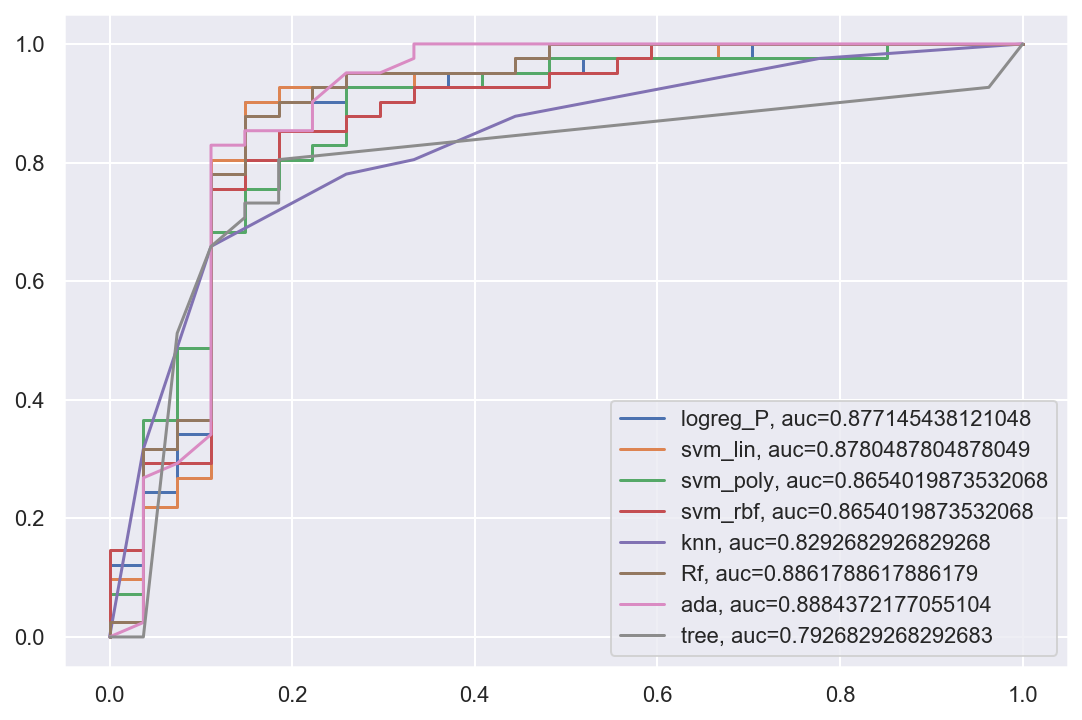

In [470]:
plt.figure(0).clf()

pred = pred_log
label = Ytest_log
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="logreg_P, auc="+str(auc))

pred = pred_svm_lin
label = Y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="svm_lin, auc="+str(auc))


pred = pred_svm_poly
label = Y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="svm_poly, auc="+str(auc))

pred = pred_svm_rbf
label = Y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="svm_rbf, auc="+str(auc))


pred = pred_knn
label = Y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="knn, auc="+str(auc))

pred = pred_rf
label = Y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="Rf, auc="+str(auc))

pred = pred_ada
label = Y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="ada, auc="+str(auc))

pred = pred_tree
label = Y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="tree, auc="+str(auc))


plt.legend(loc=0)